# Mercado Livre API - Visitas às páginas dos produtos
Esse notebook apresenta visitas a itens resultantes de uma query definida pelo usuário. É possível ajustar o número de itens a serem plotados no gráfico (*ITEMS_TO_PLOT*), bem como o número de dias atrás que se deseja iniciar a consulta (*DAYS_AGO*).

O código é composto por 3 partes:

### Busca de itens a partir de uma query definida pelo usuário

- Get dos resultados da busca
- Ordenamento dos itens por mais vendidos e remoção de itens duplicados
- Corte de itens pelo limite *ITEMS_TO_PLOT*

### Request por visitas dos itens filtrados e ordenados

- Get das visitas dos itens desde *DAYS_AGO* dias atrás 
- Organização dos resultados em um único **df** indexado por data
- Headers das colunas editados para serem as ids dos itens

### Visualização dos dados de 3 formas
- Visitas por dia (básico)
- Média móvel de visitas (janela da média definida no código, ainda hardcoded)
- Soma acumulada de visitas

Ao final são listados os títulos dos itens e respectivas URLs para visualização da página.

## Imports e configurações gerais

In [37]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

import requests
import pandas as pd

from pandas import Series, DataFrame

# Charts styling

#plt.style.use('fivethirtyeight')
#plt.style.use('bmh')
plt.style.use('ggplot')
from pylab import rcParams
rcParams['figure.figsize'] = 15, 8 # increases figure size
matplotlib.rcParams.update({'font.size': 14}) # increases chart font size
rcParams['font.family'] = 'Arial Narrow'



In [2]:
# style to enhance df viz, from https://github.com/brandon-rhodes/pycon-pandas-tutorial
from IPython.core.display import HTML
css = open('style-table.css').read() #+ open('style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

## Parâmetros de entrada

In [3]:
# Sets input parameters 
DAYS_AGO = 365 # days to look back in visits history
ITEMS_TO_PLOT = 10 # list of "ITEMS_TO_PLOT" top sold items; e.g. if 10, visits from top 10 sold itens will be plotted

## Busca de itens a partir de uma query definida pelo usuário

- Get dos resultados da busca
- Ordenamento dos itens por mais vendidos e remoção de itens duplicados
- Corte de itens pelo limite *ITEMS_TO_PLOT*

In [4]:
### REQUEST: gets items according to search for 'query' 

query = "kit painel solar"
#query = input('Qual a query desejada? ')

url = "https://api.mercadolibre.com/sites/MLB/search?q=" + query
print('Busca por ' + query)
data = requests.get(url).json()

results = data["results"] # saves content from json in variable
df = DataFrame(results) # converts to a pandas df

df = df[["id", "title", "price", "sold_quantity", "available_quantity", "permalink"]] # gets only interesting columns

# sorts items by sold quantity and deletes duplicates with less sales (assuming they'd be 0)
df = df.sort_values(by="sold_quantity", ascending=False)
df = df.drop_duplicates(subset=['title'], keep='first')

ids = df.id.values[0:ITEMS_TO_PLOT] # gets top sold items ML ids in a list

df = df.set_index('id') # sets index to id

df.head()

Busca por kit painel solar


,title,price,sold_quantity,available_quantity,permalink
id,,,,,
MLB712968328,Kit Painel Solar Fotovoltaico E Controlador De...,354.9,97,6,http://produto.mercadolivre.com.br/MLB-7129683...
MLB684532632,Kit Demonstrativo Célula Painel Placa Energia ...,29.9,71,948,http://produto.mercadolivre.com.br/MLB-6845326...
MLB695065272,Kit Painel Solar Placa Célula Fotovoltaica 150...,1459.0,55,963,http://produto.mercadolivre.com.br/MLB-6950652...
MLB754575430,Kit Painel Solar+ Bateria+ Controlador+ Invers...,798.0,25,5,http://produto.mercadolivre.com.br/MLB-7545754...
MLB727650542,Kit Painel Placa Energia Solar 150w + Controla...,829.0,18,10,http://produto.mercadolivre.com.br/MLB-7276505...


In [5]:
df.describe()

,price,sold_quantity,available_quantity
count,43.000000,43.000000,43.000000
mean,2315.719070,7.906977,627.023256
std,2807.695268,19.621191,2073.250812
min,29.900000,0.000000,1.000000
25%,798.950000,0.000000,2.000000
50%,962.970000,2.000000,5.000000
75%,2522.000000,4.000000,80.000000
max,13999.000000,97.000000,9760.000000


In [63]:
df.head()

,title,price,sold_quantity,available_quantity,permalink
id,,,,,
MLB712968328,Kit Painel Solar Fotovoltaico E Controlador De...,354.9,97,6,http://produto.mercadolivre.com.br/MLB-7129683...
MLB684532632,Kit Demonstrativo Célula Painel Placa Energia ...,29.9,71,948,http://produto.mercadolivre.com.br/MLB-6845326...
MLB695065272,Kit Painel Solar Placa Célula Fotovoltaica 150...,1459.0,55,963,http://produto.mercadolivre.com.br/MLB-6950652...
MLB754575430,Kit Painel Solar+ Bateria+ Controlador+ Invers...,798.0,25,5,http://produto.mercadolivre.com.br/MLB-7545754...
MLB727650542,Kit Painel Placa Energia Solar 150w + Controla...,829.0,18,10,http://produto.mercadolivre.com.br/MLB-7276505...


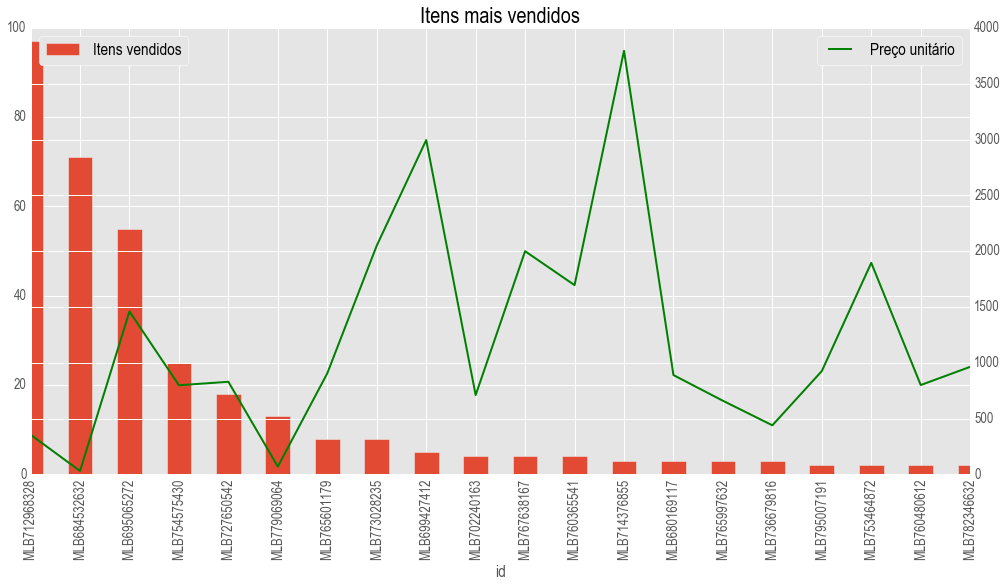

In [108]:
# sold quantity vs. unit price

# procedure to handle secondary Y axis
fig0, ax0 = plt.subplots()
ax1 = ax0.twinx()

y0 = df.head(20).sold_quantity.plot(kind='bar', ax=ax0, label='Itens vendidos')
y1 = df.head(20).price.plot(secondary_y=True, style='g', ax=ax1, label='Preço unitário')
y0.legend(loc=2) # bar legend to the left
y1.legend(loc=0) # line legend to the right

plt.title('Itens mais vendidos', fontsize=22)
plt.show()
plt.close()

In [ ]:
# total amount of each item (sold + stock)

df[]

## Request por visitas dos itens filtrados e ordenados

- Get das visitas dos itens desde *DAYS_AGO* dias atrás 
- Organização dos resultados em um único **df** indexado por data
- Headers das colunas editados para serem as ids dos itens

In [13]:
#### REQUEST: get visits (by days) for the items in 'ids'

days = DAYS_AGO # number of days ago to consider
ids_string = ','.join(ids) # makes comma-separated string from list to use in URL

url = 'https://api.mercadolibre.com/items/visits/time_window?ids=' + ids_string +'&last=' + str(days) + '&unit=day'
data = requests.get(url).json()

visits_df = DataFrame(data[0]['results']) # initialize a df with the first item out of 10 (top ten in ids_string)
visits_df = visits_df[['date', 'total']] # gets only main columns
visits_df.columns = ['date', data[0]['item_id']] # renames 'total' to item's ID

column_headers = [] # list to store item ids used as column headers
column_headers.append(data[0]['item_id'])

# iterates over data items to merge all 'total' columns into same df
for item in data[1:]:
    results = item['results']
    df_temp = DataFrame(results)
    df_temp = df_temp[['date', 'total']]
    df_temp.columns = ['date', item['item_id']]
    column_headers.append(item['item_id'])
    visits_df = pd.merge(visits_df, df_temp, on='date')
    
#print(column_headers)
#visits_df.head()

In [14]:
# fixes df, parsing 'date' properly and setting as index column
visits_df['date'] = pd.to_datetime(visits_df['date'])
visits_df = visits_df.set_index('date')

visits_df.head()

,MLB712968328,MLB684532632,MLB695065272,MLB754575430,MLB727650542,MLB779069064,MLB765601179,MLB773028235,MLB699427412,MLB702240163
date,,,,,,,,,,
2015-10-17 04:00:00,139,12,145,0,0,0,0,0,61,35
2015-10-18 04:00:00,119,12,145,0,0,0,0,0,60,37
2015-10-19 04:00:00,147,12,162,0,0,0,0,0,80,58
2015-10-20 04:00:00,130,24,144,0,0,0,0,0,66,57
2015-10-21 04:00:00,133,13,199,0,0,0,0,0,75,45


## Visualização dos dados de 3 formas
- Visitas por dia (básico)
- Média móvel de visitas (janela da média definida no código, ainda hardcoded)
- Soma acumulada de visitas

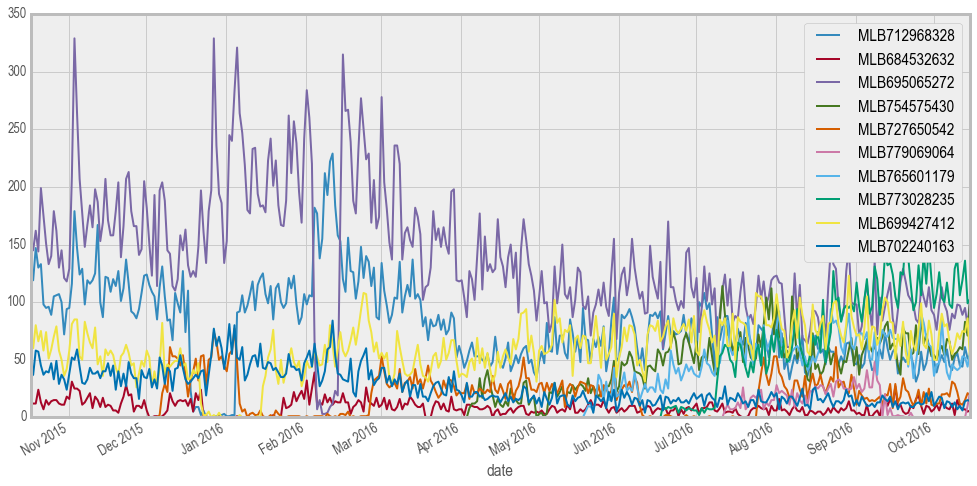

In [31]:
plt.figure()
visits_df.plot(legend=True);

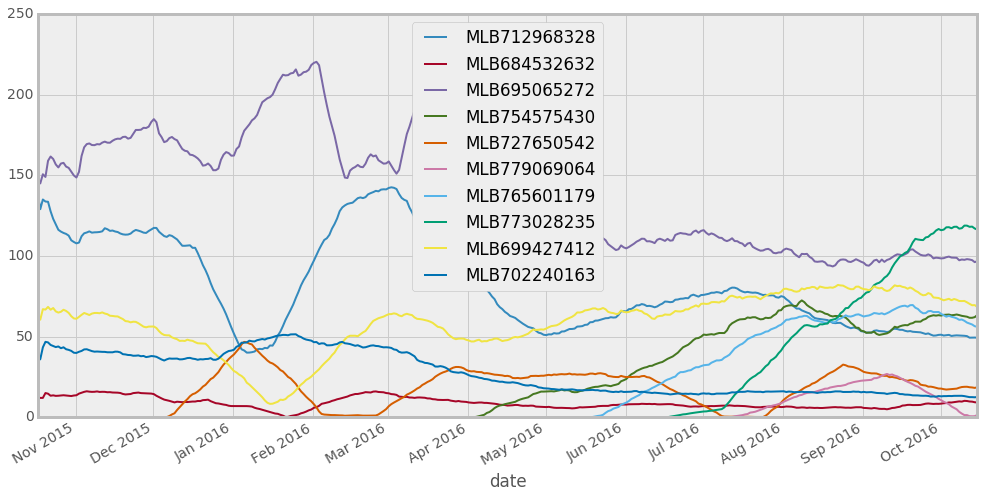

In [26]:
# calculates and plots visits' rolling mean (smoother curves)
#rolling_mean_df = visits_df.resample("1d").sum().fillna(0).rolling(window=30, min_periods=1).mean() #when resampling is needed

plt.figure();
rolling_mean_df = visits_df.rolling(window=30, min_periods=1).mean() # window is the # of days evaluated in rolling mean
rolling_mean_df.plot();

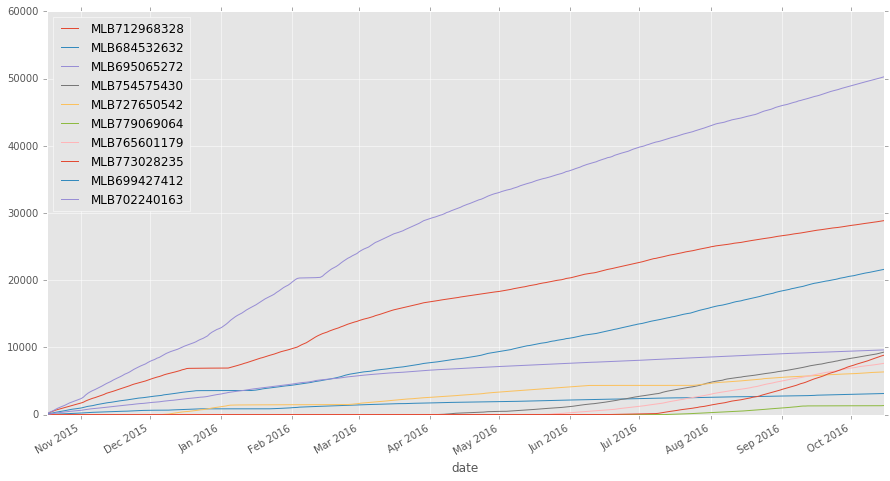

In [17]:
cumulative_visits_df = visits_df.cumsum() # calculates accumulated values to plot
plt.figure();
cumulative_visits_df.plot(legend=True);

## Lista dos itens plotados e URLs

In [18]:
# prints URLs from items in chart

print('URLs dos itens plotados:', '\n')
for item in column_headers:
    print(item + ' - ' + df.loc[item, 'title']) # uses loc taking advantage of indexing by id made previously
    print(df.loc[item, 'permalink'])
    

URLs dos itens plotados: 

MLB712968328 - Kit Painel Solar Fotovoltaico E Controlador De Carga
http://produto.mercadolivre.com.br/MLB-712968328-kit-painel-solar-fotovoltaico-e-controlador-de-carga-_JM
MLB684532632 - Kit Demonstrativo Célula Painel Placa Energia Solar 6v 150ma
http://produto.mercadolivre.com.br/MLB-684532632-kit-demonstrativo-celula-painel-placa-energia-solar-6v-150ma-_JM
MLB695065272 - Kit Painel Solar Placa Célula Fotovoltaica 150w + Acessórios
http://produto.mercadolivre.com.br/MLB-695065272-kit-painel-solar-placa-celula-fotovoltaica-150w-acessorios-_JM
MLB754575430 - Kit Painel Solar+ Bateria+ Controlador+ Inversor 12v P/110v
http://produto.mercadolivre.com.br/MLB-754575430-kit-painel-solar-bateria-controlador-inversor-12v-p110v-_JM
MLB727650542 - Kit Painel Placa Energia Solar 150w + Controlador 20a + Cabo
http://produto.mercadolivre.com.br/MLB-727650542-kit-painel-placa-energia-solar-150w-controlador-20a-cabo-_JM
MLB779069064 - Kit Célula Solar Para Montar Painel 